# **1, Import necessary libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# **2, Import the dataset**

In [2]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [30]:
# Import the dataset
dataset = pd.read_csv("/content/drive/MyDrive/CarPricePrediction/Remove-null-car_name-and-fill-null.csv")

# Split features and target column
features = ['origin', 'car_model', 'mileage', 'exterior_color', 'interior_color', 'num_of_doors',
            'seating_capacity', 'engine', 'engine_capacity', 'transmission', 'drive_type',
            'fuel_consumption', 'brand', 'grade', 'year_of_manufacture']
target = 'price_in_billion'
X = dataset[features] # X = dataset.iloc[:, :-1]
y = dataset[target] # y = dataset.iloc[:, -1].reshape(-1, 1)

In [31]:
# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each categorical column and store the mapping information
# Index: Key - Feature Name, Value - Dict of Encoded Value
label_mappings = {}
for column in X.select_dtypes(include=['object']).columns:
    X[column] = le.fit_transform(X[column])
    # Store the mapping of labels to encoded values
    label_mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mappings)

# Split Train and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

{'origin': {'Domestic assembly': 0, 'Imported': 1}, 'car_model': {'Convertible/Cabriolet': 0, 'Coupe': 1, 'Crossover': 2, 'Hatchback': 3, 'Pickup': 4, 'SUV': 5, 'Sedan': 6, 'Truck': 7, 'Van/Minivan': 8, 'Wagon': 9}, 'exterior_color': {'Black': 0, 'Brown': 1, 'Colorful': 2, 'Copper': 3, 'Cream': 4, 'Different color': 5, 'Green': 6, 'Grey': 7, 'Orange': 8, 'Pink': 9, 'Red': 10, 'Sand': 11, 'Silver': 12, 'Violet': 13, 'White': 14, 'Yellow': 15}, 'interior_color': {'Black': 0, 'Brown': 1, 'Colorful': 2, 'Copper': 3, 'Cream': 4, 'Default Value': 5, 'Different color': 6, 'Green': 7, 'Grey': 8, 'Orange': 9, 'Pink': 10, 'Red': 11, 'Sand': 12, 'Silver': 13, 'Violet': 14, 'White': 15, 'Yellow': 16}, 'engine': {'Diesel': 0, 'Electric': 1, 'Hybrid': 2, 'Petrol': 3}, 'transmission': {'Automatic': 0, 'Manual': 1}, 'drive_type': {'-': 0, '4WD': 1, '4WD or AWD': 2, 'AWD': 3, 'FWD': 4, 'RFD': 5}, 'brand': {'Acura': 0, 'Audi': 1, 'BMW': 2, 'BYD': 3, 'Baic': 4, 'Bentley': 5, 'Brilliance': 6, 'Buick': 7, 

<ipython-input-31-acbe04000dce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-31-acbe04000dce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-31-acbe04000dce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

# **3, Training the model**

# a, Decision Tree

In [5]:
# Import necessary libraries
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Initialize the model
dt_model = DecisionTreeRegressor(random_state=42)

# Calculate candidate alphas
path = dt_model.cost_complexity_pruning_path(X_train, y_train)
alpha_set = path['ccp_alphas']
print(alpha_set)
# Candidate params for GridSearchCV
search_space = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [3, 7, 10, 15, 20],
    'ccp_alpha': alpha_set
}

# Calculate best hyperparams using GridSearchCV
dt_gs = GridSearchCV(estimator=dt_model,
                     param_grid=search_space,
                     scoring=['r2', 'neg_mean_squared_error'],
                     refit='r2',
                     cv=5,
                     verbose=2,
                     n_jobs=-1)
dt_gs.fit(X_train, y_train)
dt_best_params = dt_gs.best_params_

# Save all hyperparams in csv file
df = pd.DataFrame(dt_gs.cv_results_)
df.to_csv('/content/drive/MyDrive/CarPricePrediction/DecisionTreeGSResults.csv')

[ 0.00000000e+00 -1.45372030e-19 -1.55782925e-20 ...  7.40252822e-03
  1.91998016e-02  2.73765730e-02]
Fitting 5 folds for each of 270500 candidates, totalling 1352500 fits


KeyboardInterrupt: 

In [6]:
# Train the model
# dt_model = DecisionTreeRegressor(max_depth=dt_best_params['max_depth'],
#                                  min_samples_leaf=dt_best_params['min_samples_leaf'],
#                                  ccp_alpha=dt_best_params['ccp_alpha'],
#                                  random_state=42)

# Best params after GS
dt_model = DecisionTreeRegressor(max_depth=20,
                                 min_samples_leaf=3,
                                 ccp_alpha=1.0085633759065575e-06,
                                 random_state=42)
dt_model.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=1.0085633759065575e-06, max_depth=20,
                      min_samples_leaf=3, random_state=42)

In [ ]:
# Predict training results
y_pred = dt_model.predict(X_train)
r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
print("---------- TRAIN SET ----------")
print(f"Mean Squared Error: {mse}")
print(f"R² score: {r2}")

# Predict test results
y_pred = dt_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("---------- TEST SET ----------")
print(f"Mean Squared Error: {mse}")
print(f"R² score: {r2}")

---------- TRAIN SET ----------
Mean Squared Error: 0.004315907333075696
R² score: 0.9683383023812454
---------- TEST SET ----------
Mean Squared Error: 0.01118242810077721
R² score: 0.9207898911676811


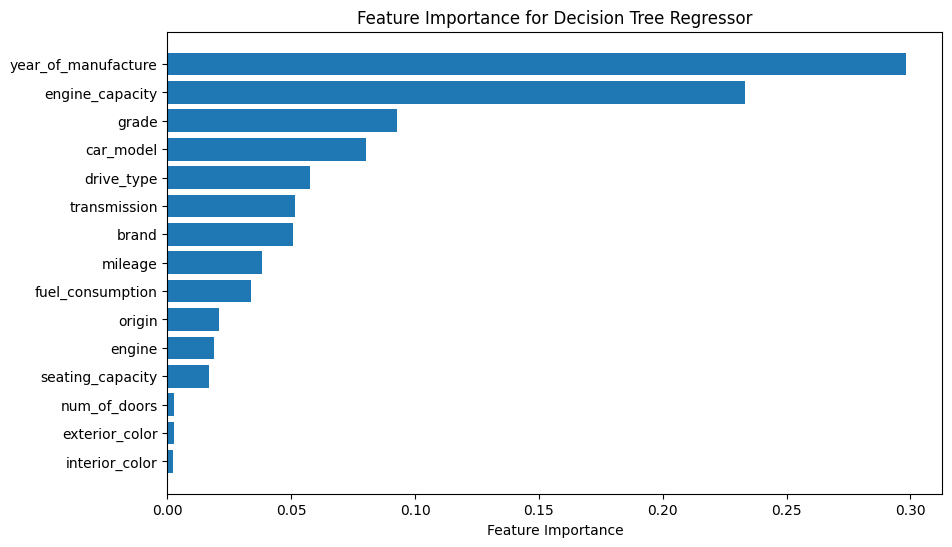

In [8]:
# Get feature importances
feature_importances = dt_model.feature_importances_
feature_names = features

# Plot feature importances
plt.figure(figsize=(10, 6))
indices = np.argsort(feature_importances)
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Decision Tree Regressor')
plt.show()

# b, Random Forest

In [9]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Candidate params for GridSearchCV
search_space = {
    'n_estimators': [10, 50, 100, 200, 300, 500, 700, 1000],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [5, 10, 15],
    'max_features': [3, 7, None],
    'max_samples': [0.2, 0.4, 0.6, 0.8],
    'bootstrap': [True]
}

# Calculate best hyperparams using GridSearchCV
rf_gs = GridSearchCV(estimator=rf_model,
                     param_grid=search_space,
                     scoring=['r2', 'neg_mean_squared_error'],
                     refit='r2',
                     cv=5,
                     verbose=2,
                     n_jobs=-1)
rf_gs.fit(X_train, y_train)
rf_best_params = rf_gs.best_params_

# Save all hyperparams in csv file
df = pd.DataFrame(rf_gs.cv_results_)
df.to_csv('/content/drive/MyDrive/CarPricePrediction/RandomForestGSResults.csv')

Fitting 5 folds for each of 756 candidates, totalling 3780 fits


KeyboardInterrupt: 

In [10]:
# Train the model
# rf_model = RandomForestRegressor(n_estimators=rf_best_params['n_estimators'],
#                                  max_depth=rf_best_params['max_depth'],
#                                  min_samples_leaf=rf_best_params['min_samples_leaf'],
#                                  max_features=rf_best_params['max_features'],
#                                  max_samples=rf_best_params['max_samples'],
#                                  bootstrap=rf_best_params['bootstrap'],
#                                  oob_score=True,
#                                  random_state=42)

# Best params after GS
rf_model = RandomForestRegressor(n_estimators=500,
                                 max_depth=20,
                                 min_samples_leaf=5,
                                 max_features=7,
                                 max_samples=0.8,
                                 bootstrap=True,
                                 oob_score=True,
                                 random_state=42)
rf_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, max_features=7, max_samples=0.8,
                      min_samples_leaf=5, n_estimators=500, oob_score=True,
                      random_state=42)

In [ ]:
# Predict training results
y_pred = rf_model.predict(X_train)
r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
oob_score = rf_model.oob_score_
oob_mse = mean_squared_error(y_train, rf_model.oob_prediction_)
print("---------- TRAIN SET ----------")
print(f"Mean Squared Error: {mse}")
print(f"R² score: {r2}")
print(f"OOB Score: {oob_score}")
print(f"OOB Error (MSE): {oob_mse}")

# Predict test results
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("---------- TEST SET ----------")
print(f"Mean Squared Error: {mse}")
print(f"R² score: {r2}")

---------- TRAIN SET ----------
Mean Squared Error: 0.006022101526572682
R² score: 0.9558215821497017
OOB Score: 0.9346470738547188
OOB Error (MSE): 0.008908466519536801
---------- TEST SET ----------
Mean Squared Error: 0.009002084131721702
R² score: 0.9362342366644139


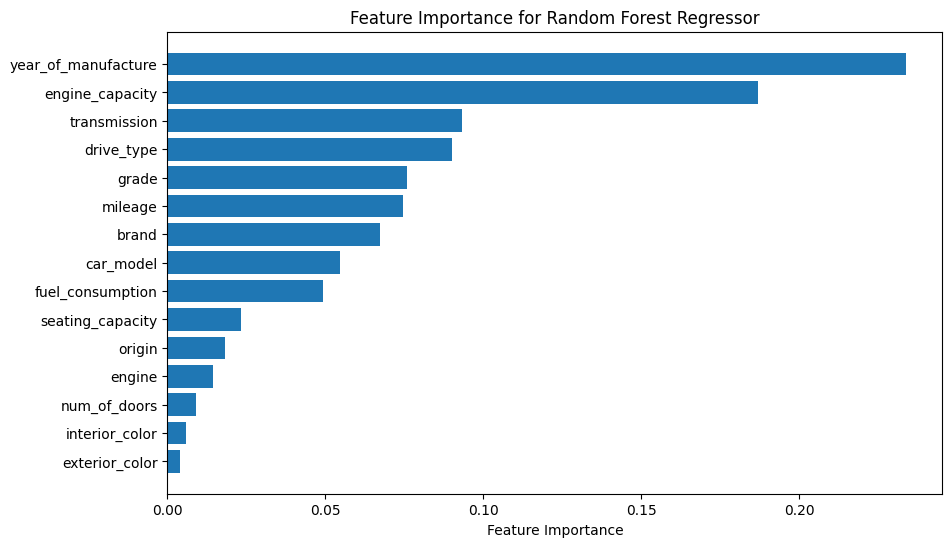

In [12]:
# Get feature importances
feature_importances = rf_model.feature_importances_
feature_names = features

# Plot feature importances
plt.figure(figsize=(10, 6))
indices = np.argsort(feature_importances)
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Random Forest Regressor')
plt.show()

# c, AdaBoost

In [13]:
# Import necessary libraries
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Initialize the model
ab_model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=7), random_state=42)

# Candidate params for GridSearchCV
search_space = {
    'n_estimators': [10, 50, 100, 200, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    'loss': ['linear', 'square', 'exponential']
}

# Calculate best hyperparams using GridSearchCV
ab_gs = GridSearchCV(estimator=ab_model,
                     param_grid=search_space,
                     scoring=['r2', 'neg_mean_squared_error'],
                     refit='r2',
                     cv=5,
                     verbose=2,
                     n_jobs=-1)
ab_gs.fit(X_train, y_train)
ab_best_params = ab_gs.best_params_

# Save all hyperparams in csv file
df = pd.DataFrame(ab_gs.cv_results_)
df.to_csv('/content/drive/MyDrive/CarPricePrediction/AdaBoostGSResults.csv')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 

In [14]:
# Train the model
# ab_model = AdaBoostRegressor(n_estimators=ab_best_params['n_estimators'],
#                              learning_rate=ab_best_params['learning_rate'],
#                              loss=ab_best_params['loss'],
#                              estimator=DecisionTreeRegressor(max_depth=7),
#                              random_state=42)

# Best params after GS
ab_model = AdaBoostRegressor(n_estimators=100,
                             learning_rate=0.3,
                             loss='exponential',
                             estimator=DecisionTreeRegressor(max_depth=10),
                             random_state=42)
ab_model.fit(X_train,y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10),
                  learning_rate=0.3, loss='exponential', n_estimators=100,
                  random_state=42)

In [ ]:
# Predict training results
y_pred = ab_model.predict(X_train)
r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
print("---------- TRAIN SET ----------")
print(f"Mean Squared Error: {mse}")
print(f"R² score: {r2}")

# Predict test results
y_pred = ab_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("---------- TEST SET ----------")
print(f"Mean Squared Error: {mse}")
print(f"R² score: {r2}")

---------- TRAIN SET ----------
Mean Squared Error: 0.00411817109470826
R² score: 0.9697889046542553
---------- TEST SET ----------
Mean Squared Error: 0.008068552242230981
R² score: 0.9428468579930376


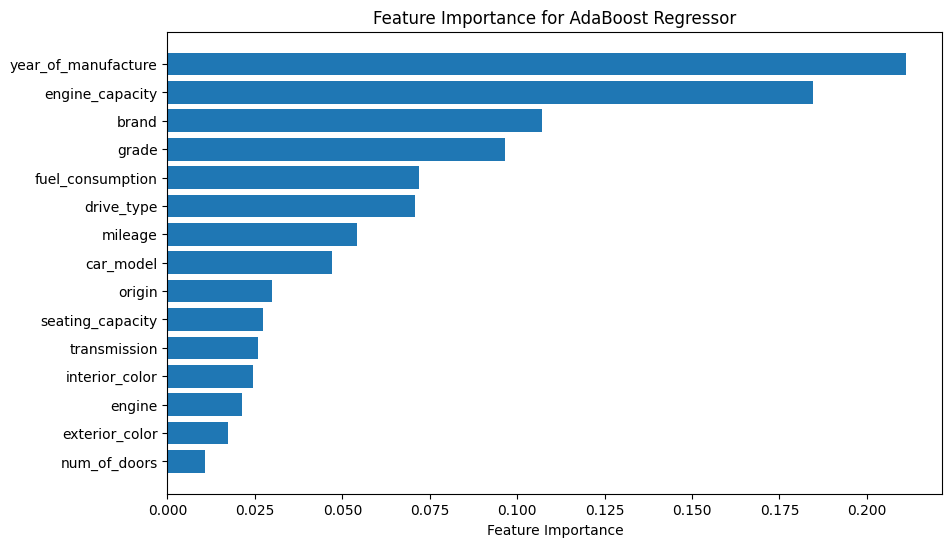

In [15]:
# Get feature importances
feature_importances = ab_model.feature_importances_
feature_names = features

# Plot feature importances
plt.figure(figsize=(10, 6))
indices = np.argsort(feature_importances)
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for AdaBoost Regressor')
plt.show()

# d, Gradient Boost

In [16]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# Initialize the model
gb_model = GradientBoostingRegressor(random_state=42)

# Candidate params for GridSearchCV
search_space = {
    'n_estimators': [50, 100, 200, 300, 500, 700, 1000],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Calculate best hyperparams using GridSearchCV
gb_gs = GridSearchCV(estimator=gb_model,
                     param_grid=search_space,
                     scoring=['r2', 'neg_mean_squared_error'],
                     refit='r2',
                     cv=5,
                     verbose=2,
                     n_jobs=-1)
gb_gs.fit(X_train, y_train)
gb_best_params = gb_gs.best_params_

# Save all hyperparams in csv file
df = pd.DataFrame(gb_gs.cv_results_)
df.to_csv('/content/drive/MyDrive/CarPricePrediction/GradientBoostGSResults.csv')

Fitting 5 folds for each of 448 candidates, totalling 2240 fits


KeyboardInterrupt: 

In [17]:
# Train the model
# gb_model = GradientBoostingRegressor(n_estimators=gb_best_params['n_estimators'],
#                                      max_depth=gb_best_params['max_depth'],
#                                      min_samples_split=gb_best_params['min_samples_split'],
#                                      learning_rate=gb_best_params['learning_rate'],
#                                      random_state=42)

# Best params after GS
gb_model = GradientBoostingRegressor(n_estimators=1000,
                                     max_depth=7,
                                     min_samples_split=20,
                                     learning_rate=0.05,
                                     random_state=42)
gb_model.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=7, min_samples_split=20,
                          n_estimators=1000, random_state=42)

In [ ]:
# Predict training results
y_pred = gb_model.predict(X_train)
r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
print("---------- TRAIN SET ----------")
print(f"Mean Squared Error: {mse}")
print(f"R² score: {r2}")

# Predict test results
y_pred = gb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("---------- TEST SET ----------")
print(f"Mean Squared Error: {mse}")
print(f"R² score: {r2}")

---------- TRAIN SET ----------
Mean Squared Error: 0.00199706994441336
R² score: 0.9853494016845681
---------- TEST SET ----------
Mean Squared Error: 0.005874080597803239
R² score: 0.9583912760941902


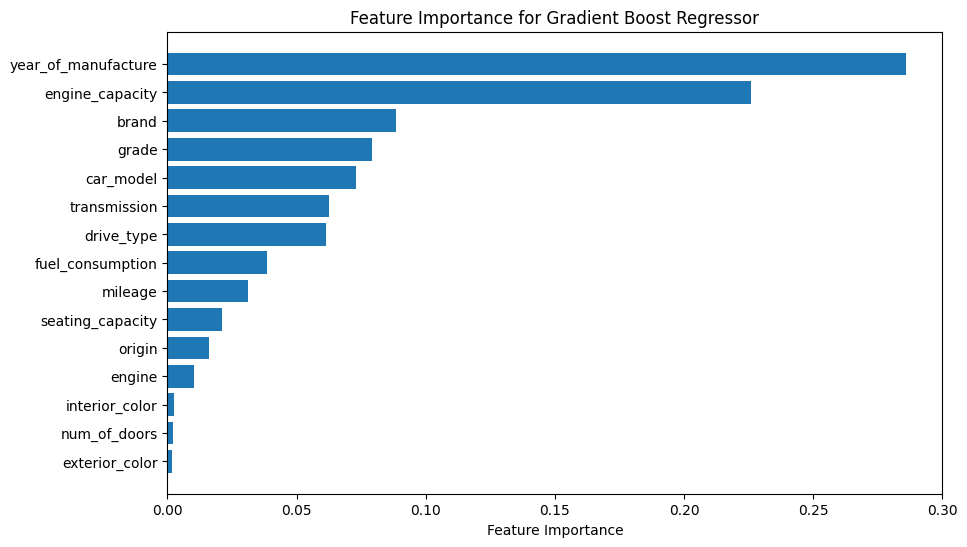

In [18]:
# Get feature importances
feature_importances = gb_model.feature_importances_
feature_names = features

# Plot feature importances
plt.figure(figsize=(10, 6))
indices = np.argsort(feature_importances)
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Gradient Boost Regressor')
plt.show()

# e, Extreme Gradient Boost

In [22]:
# Import necessary libraries
import time
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Initialize the model
xgb_model = XGBRegressor(random_state=42)

# Candidate params for RandomizedSearchCV
search_space = {
    'n_estimators': [50, 100, 200, 300, 500, 700, 1000],
    'max_depth': [3, 5, 7, 10],
    'eta': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'gamma': [0, 0.1, 0.5, 1, 5],
    'reg_lambda': [0, 0.1, 1, 10, 100]
}

# Calculate best hyperparams using RandomizedSearchCV with timeout
xgb_rs = RandomizedSearchCV(estimator=xgb_model,
                            param_distributions=search_space,
                            n_iter=20,
                            scoring=['r2', 'neg_mean_squared_error'],
                            refit='r2',
                            cv=5,
                            n_jobs=-1,
                            verbose=2,
                            random_state=42)
# Measure time for a single iteration
start_time = time.time()
xgb_rs.fit(X_train, y_train)
end_time = time.time()

# Calculate time taken for a single iteration
time_per_iteration = (end_time - start_time)/20
print(f"Time per iteration: {time_per_iteration:.2f} seconds")

# Total available time (in seconds)
total_time_available = 10 * 60 * 60  # 10 hours

# Estimate number of iterations
estimated_n_iter = total_time_available // time_per_iteration
print(f"Estimated number of iterations: {estimated_n_iter}")

# Run RandomizedSearchCV with the estimated number of iterations
xgb_rs = RandomizedSearchCV(estimator=xgb_model,
                            param_distributions=search_space,
                            n_iter=int(estimated_n_iter),
                            scoring=['r2', 'neg_mean_squared_error'],
                            refit='r2',
                            cv=5,
                            n_jobs=-1,
                            verbose=2,
                            random_state=42)
start_time = time.time()
xgb_rs.fit(X_train, y_train)
end_time = time.time()
xgb_best_params = xgb_rs.best_params_
txt = f"n_iter = {int(estimated_n_iter)} running for {round((end_time-start_time)/3600, 2)} hours"
file = "Running time.txt"
with open(file, 'w') as f:
    f.write(txt)

# Save all hyperparams in csv file
df = pd.DataFrame(xgb_rs.cv_results_)
df.to_csv('/content/drive/MyDrive/CarPricePrediction/XGBoostRSResults.csv')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [20]:
# Train the model
# xgb_model = XGBRegressor(n_estimators=xgb_best_params['n_estimators'],
#                          max_depth=xgb_best_params['max_depth'],
#                          eta=xgb_best_params['eta'],
#                          subsample=xgb_best_params['subsample'],
#                          colsample_bytree=xgb_best_params['colsample_bytree'],
#                          gamma=xgb_best_params['gamma'],
#                          reg_lambda=xgb_best_params['reg_lambda'],
#                          random_state=42)

# Best params after RS
xgb_model = XGBRegressor(n_estimators=1000,
                         max_depth=7,
                         eta=0.05,
                         subsample=0.8,
                         colsample_bytree=0.6,
                         gamma=0,
                         reg_lambda=1,
                         random_state=42)
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Predict training results
y_pred = xgb_model.predict(X_train)
r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
print("---------- TRAIN SET ----------")
print(f"Mean Squared Error: {mse}")
print(f"R² score: {r2}")

# Predict test results
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("---------- TEST SET ----------")
print(f"Mean Squared Error: {mse}")
print(f"R² score: {r2}")

---------- TRAIN SET ----------
Mean Squared Error: 0.0018089781649321286
R² score: 0.9867292517570821
---------- TEST SET ----------
Mean Squared Error: 0.005578874180634143
R² score: 0.9604823543663892


<Figure size 1000x800 with 0 Axes>

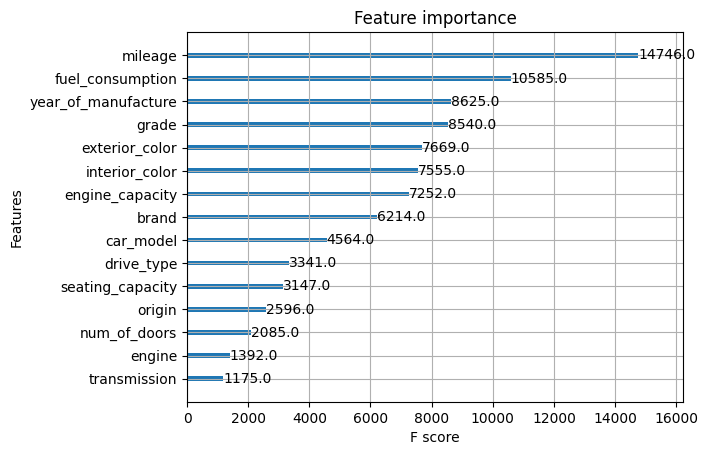

In [24]:
# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model)
plt.show()